### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 2018
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
np.random.seed(seed= 2018)
# import edward as ed
import pandas as pd

from time import time
# from edward.models import Categorical, Normal
from keras.utils import to_categorical
from plot_feature import plot_feature

import seaborn as sns
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.utils import resample
import scipy.special

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

Using TensorFlow backend.


### Sklearn related modules

In [3]:
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA

In [4]:
random_seed = 2018

In [5]:
# ed.set_seed(random_seed)

### Plot related setups

In [6]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
%matplotlib inline

plt.style.use(['default'])
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'font.family': 'serif',
}
plt.rcParams.update(params)

### Import Data

In [7]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None, dtype = np.float32)
df_val= pd.read_csv(val_file, sep=" ", header = None, dtype = np.float32)
df_test= pd.read_csv(test_file, sep=" ", header = None, dtype = np.float32)

features_name =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = features_name
df_val.columns = features_name
df_test.columns = features_name

df_train_all = df_train.append(df_val)

### Data processing
We use StandardScaler preprocessing method of scikit. It standardizes features 
by removing the mean and scaling to unit variance

In [8]:
df = shuffle(df_train_all, random_state = random_seed)
df_test = shuffle(df_test, random_state = random_seed)

In [9]:
df.shape

(1600, 9)

### Class Balance

In [10]:
df.label.value_counts()

0.0    1041
1.0     559
Name: label, dtype: int64

In [11]:
df_major = df[df.label == 0]
df_minor = df[df.label == 1]

In [12]:
df_minor.shape[0]

559

In [13]:
df_minor_upsmapled = resample(df_minor, replace = True, n_samples = df_major.shape[0], random_state = 2018)

In [14]:
df_minor_upsmapled = pd.concat([df_minor_upsmapled, df_major])

In [15]:
df_minor_upsmapled.label.value_counts()

0.0    1041
1.0    1041
Name: label, dtype: int64

### Analysis

In [16]:
features =['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc']

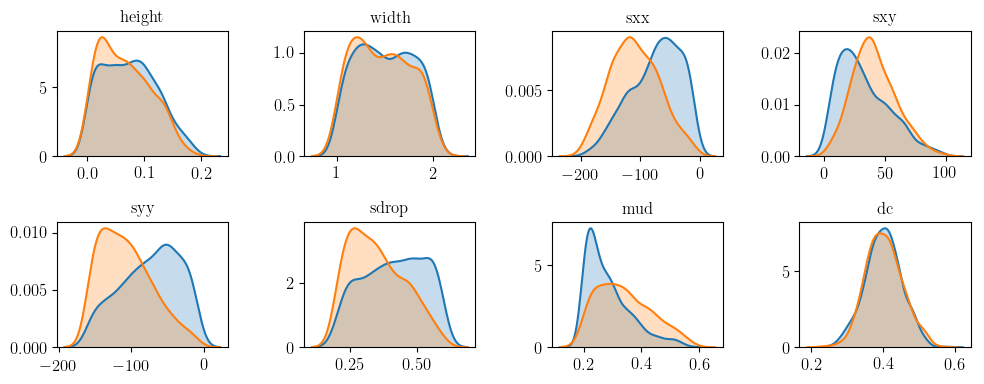

In [17]:
plt.figure(figsize=(10, 4))

for i, feature in enumerate(features):
    plt.subplot(2, 4, i + 1)
    sns.kdeplot(df[feature][df.label == 0], shade= True, legend=False)
    sns.kdeplot(df[feature][df.label == 1], shade= True, legend=False)
    plt.title(feature)
    
plt.tight_layout()
plt.show()

### Fetaure Scaling

In [18]:
mms = StandardScaler()
train_scale = mms.fit(df_minor_upsmapled.drop('label', axis=1))

xtrain = train_scale.transform(df_minor_upsmapled.drop('label', axis=1))
ytrain =  np.array(df_minor_upsmapled['label'].values)
ytrain = ytrain.reshape(ytrain.shape[0], 1)

xtest = train_scale.transform(df_test.drop('label', axis=1))
ytest = np.array(df_test['label'].values)
ytest = ytest.reshape(ytest.shape[0], 1)

In [19]:
np.shape(xtrain)

(2082, 8)

### Feature analysis

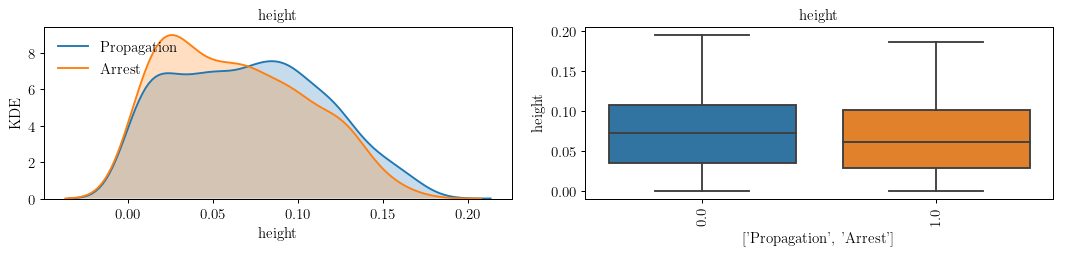

In [20]:
plot_feature(df, 'height', True, False)

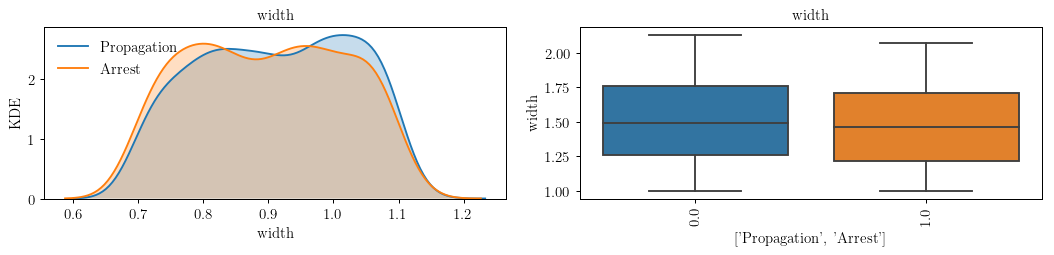

In [21]:
plot_feature(df, 'width', True, False)

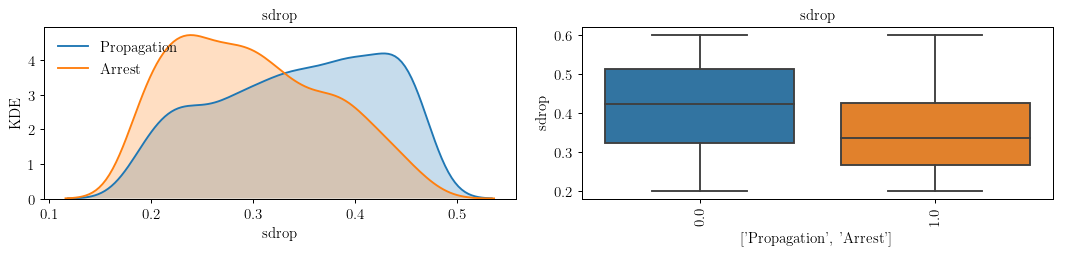

In [22]:
plot_feature(df, 'sdrop', True, False)

In [23]:
from sklearn.linear_model import Lasso, Ridge

In [24]:
#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (np.round(coef, 3), name)
                                   for coef, name in lst)

In [25]:
lasso = Lasso(alpha=0.0005)
lasso.fit(xtrain, ytrain)
print("Lasso model: ", pretty_print_linear(lasso.coef_, features, sort = False))

ridge = Ridge(alpha=10)
ridge.fit(xtrain, ytrain)
print("Ridge model: ", pretty_print_linear(ridge.coef_, features, sort = False))

Lasso model:  -0.032 * height + -0.018 * width + -0.085 * sxx + -0.002 * sxy + -0.098 * syy + -0.049 * sdrop + 0.111 * mud + 0.008 * dc
Ridge model:  [-0.032 -0.019 -0.086 -0.008 -0.103 -0.046  0.111  0.008] * height


## Model setup

### 1. Hyperparameters 

In [26]:
## Hyperparameters
N = np.shape(xtrain)[0]
in_size = np.shape(xtrain)[1]
out_size = 1
l1 = 12 # Number of neurons in the first layer
BATCH_SIZE = 32

### 2. Define neural network

In [35]:
def neural_network(xdata, W_0, W_1, b_0, b_1):
    hidden1 = tf.nn.relu(tf.matmul(W_0.sample(), xdata) + b_0)
    output = tf.nn.sigmoid(tf.matmul(W_1.sample(), hidden1) + b_1)
    
    return output

In [ ]:
def define_network(images, num_classes=10):
    
     mean = tf.get_variable('mean', [28 * 28, num_classes])
     stddev = tf.get_variable('stddev', [28 * 28, num_classes])
    
     prior = tfd.MultivariateNormalDiag(
     tf.zeros_like(mean), tf.ones_like(stddev))
        
     posterior = tfd.MultivariateNormalDiag(mean, tf.nn.softplus(stddev))
    
     bias = tf.get_variable('bias', [num_classes]) # Or Bayesian, too
        
     logit = tf.nn.relu(tf.matmul(posterior.sample(), images) + bias)
    
     return tfd.Categorical(logit), posterior, prior

dist, posterior, prior = define_network(images)

elbo = (tf.reduce_mean(dist.log_prob(label)) -
 tf.reduce_mean(tfd.kl_divergence(posterior, prior))

### 3. Model Prior parameter distributions

In [36]:
with tf.name_scope('model_prior'):
    
    W_0 = tfp.distributions.Normal(loc = tf.zeros([in_size, l1], name="weights/loc_w_0"), 
                 scale=tf.ones([in_size, l1], name="weights/scale_w_0"),
                 name  = 'weight_w_0')
    
    W_1 = tfp.distributions.Normal(loc=tf.zeros([l1, out_size], name="weights/loc_w_1"), 
                 scale=tf.ones([l1, out_size], name="weights/scale_w_1"),
                 name  = 'weight_w_1')
    
    b_0 = tfp.distributions.Normal(loc=tf.zeros(l1, name="weights/loc_b_0"), 
                 scale=tf.ones(l1, name="weights/scale_b_0"),
                 name  = 'weight_b_0')
    
    b_1 = tfp.distributions.Normal(loc=tf.zeros(out_size, name="weights/loc_b_1"),
                 scale=tf.ones(out_size, name="weights/scale_b_1"),
                 name  = 'weight_b_1')

    X = tf.placeholder(tf.float32, shape = (None, in_size)) 
    y = tfp.distributions.Normal(loc = neural_network(X, W_0, W_1, b_0, b_1), scale = 1.0)

TypeError: Expected float32, got <tfp.distributions.Normal 'model_prior_4/weight_b_0/' batch_shape=(12,) event_shape=() dtype=float32> of type 'Normal' instead.

### Model posterior weights

In [85]:
with tf.name_scope('posterior'):
    qW_0 = Normal(loc = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/loc_qw_0" ), 
                  scale = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/scale_qw_0"),
                  name = "weight_qw_0")
    
    qW_1 = Normal(loc = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ), 
                  scale = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ),
                  name = "weight_qw_1")
    
    qb_0 = Normal(loc = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ), 
                scale = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ),
                name = "weight_qb_0")
    qb_1 = Normal(loc = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ), 
                scale = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ),
                name = "weight_qb_1")

## Inference

In [86]:
with tf.name_scope("inference"):
    
    inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                         W_1: qW_1, b_1: qb_1}, 
                        data={X: xtrain, 
                              y: ytrain})

    global_step = tf.Variable(0, trainable=False, name = "global_step")
    initial_learning_rate = tf.Variable(0.05, trainable = False, name = "initial_learning_rate")

    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               10000, 0.3, staircase=True)

    optimizer = tf.train.AdamOptimizer(learning_rate)

    inference.run(n_iter = 4000, optimizer = optimizer, global_step = global_step, logdir = r'./log')

4000/4000 [100%] ██████████████████████████████ Elapsed: 12s | Loss: 2227.412


## Sampling 

In [87]:
%time

n_samples = 1500

qW_0_samples = qW_0.sample(sample_shape=n_samples)
qW_1_samples = qW_1.sample(sample_shape=n_samples)
qb_0_samples = qb_0.sample(sample_shape=n_samples)
qb_1_samples = qb_1.sample(sample_shape=n_samples)

print("Preparing to sample...")

t0 = time()
samplenodes = tf.stack([neural_network(X, qW_0_samples[i], qW_1_samples[i],
                                       qb_0_samples[i], qb_1_samples[i]) 
                        for i in range(n_samples)], axis=0)

print("Took", np.int(time() - t0), "secs.")

print("Sampling...")
t0 = time()
samplepredictions = samplenodes.eval(feed_dict={X: xtest})
print("Took", np.int(time() - t0), "secs.")
predictions_samp = samplepredictions[:, :, 0]

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 21 µs
Preparing to sample...
Took 27 secs.
Sampling...
Took 14 secs.


### Prior and posterior weight vizualization

In [88]:
### prior weights
prior_weights = W_0.eval(), W_1.eval(), b_0.eval(), b_1.eval()

### Posterior mean weights
post_weights_mean = qW_0_samples.eval().mean(axis = 0), qW_1_samples.eval().mean(axis = 0),\
               qb_0_samples.eval().mean(axis = 0), qb_1_samples.eval().mean(axis = 0)

In [89]:
### Posterior mean weights
post_weights_std = qW_0_samples.eval().std(axis = 0), qW_1_samples.eval().std(axis = 0),\
               qb_0_samples.eval().std(axis = 0), qb_1_samples.eval().std(axis = 0)

In [90]:
np.shape(post_weights_mean)

(4,)

In [91]:
def plot_weight_distribution(prior = True):

    plt.figure(figsize=(8, 6))
    
    wgt = ['w0', 'w1', 'b0', 'b1']
    lbl = ['a', 'b', 'c', 'd']
    
    for i in range(len(prior_weights)):
        plt.subplot(2, 2, i+1)
        if i == 3:
            plt.plot(prior_weights[i].reshape(-1), "ro", label = 'Prior')
            plt.plot(post_weights_mean[i].reshape(-1), "bo", label = 'Prior')
        else:
            sns.kdeplot(prior_weights[i].reshape(-1), shade = True, color = "r", label = 'Prior')
            sns.kdeplot(post_weights_mean[i].reshape(-1), shade = True, color = "b", label = 'Posterior')

        plt.title('(' + lbl[i] + ') ' + wgt[i])
        plt.ylabel('Density')
        plt.xlabel('Weight value')
        
    plt.legend()
    plt.tight_layout()
    plt.show()

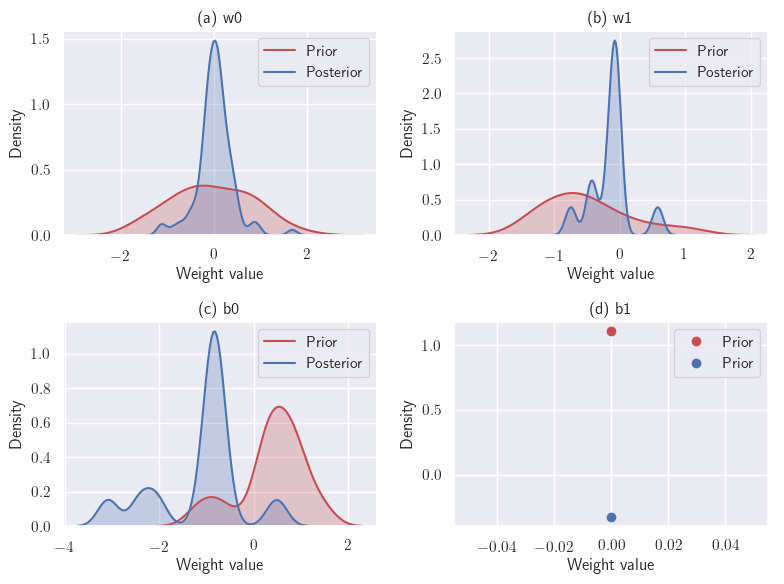

In [92]:
plot_weight_distribution()

### Model weights mean and standard deviation

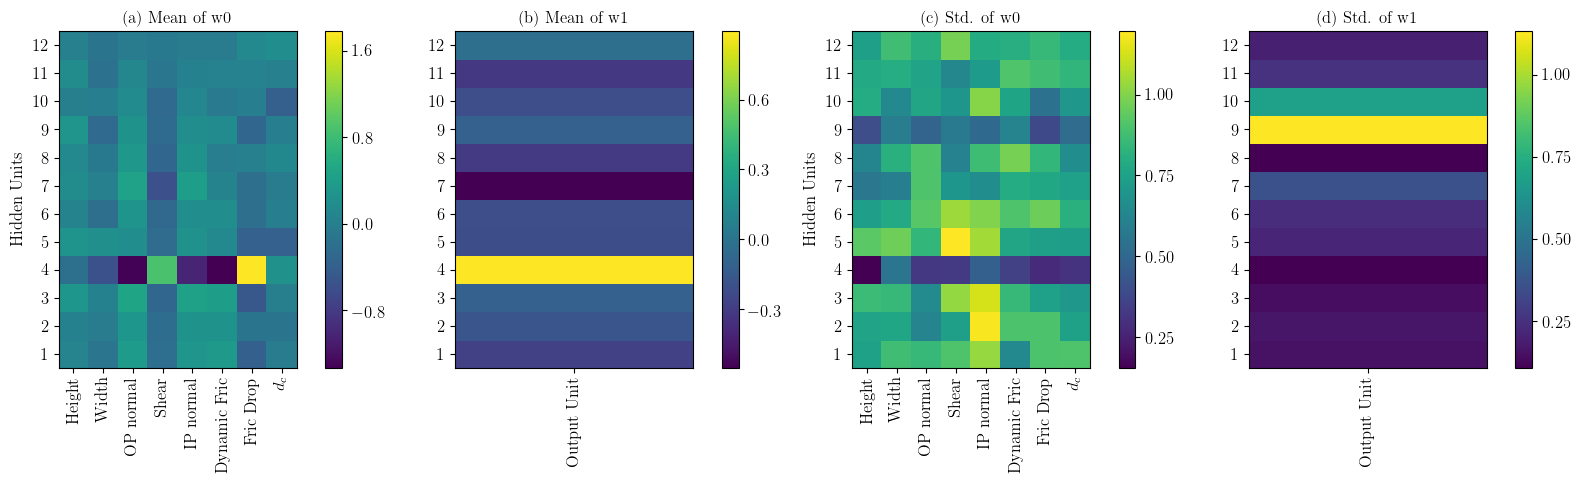

In [36]:
# %matplotlib notebook

plt.figure(figsize=(16, 5))

wgt = ['Mean of w0', 'Mean of w1', 'Std. of w0', 'Std. of w1']
lbl = ['a', 'b', 'c', 'd']

k = 0
for i in range(2):
    if i == 0:
        weights = post_weights_mean
    else:
        weights = post_weights_std
        
    plt.subplot(1,4, k + i + 1)
    aa = np.transpose(weights[0])
    plt.pcolormesh(aa, cmap = 'viridis', vmin = np.min(weights[0]), vmax = np.amax(weights[0]))
    labels = ['Height', 'Width', 'OP normal', 'Shear', 'IP normal', 'Dynamic Fric', 'Fric Drop', '$d_c$']

    plt.xticks([0.5+float(x) for x in range(0,8)], labels, rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
    plt.ylabel('Hidden Units')
    plt.title('('+ lbl[k + i] + ') ' + wgt[k + i])

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

    cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()

    # Layer two plot
    plt.subplot(1, 4, k+i+2)
    bb = np.reshape(weights[1], (12, 1))
    plt.pcolormesh(bb, cmap = 'viridis', vmin = np.min(weights[1]), vmax = np.amax(weights[1]))
    plt.xticks([0.5],['Output Unit'],rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
    plt.title('('+ lbl[k+i+1] + ') ' + wgt[k+i+1])

    cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    k = 1

plt.tight_layout()
plt.savefig('weight_vs_features.eps')
plt.show()

### Evaluation

In [93]:
###
results = pd.DataFrame()
results['target'] = list(ytest)
results.target = results.target.apply(lambda x: int(x[0]))

In [94]:
results['predictions'] = predictions_samp.mean(axis = 0)
results['pred_std'] = predictions_samp.std(axis = 0)
results['pred_var'] = predictions_samp.var(axis = 0)

In [95]:
zzz = stats.norm.interval(0.95, loc = results['predictions'], scale = results['pred_std'])
results['confidence_low'] = np.transpose(zzz)[:, 0]
results['confidence_high'] = np.transpose(zzz)[:, 1]
results['confidence_range'] = np.absolute(results['confidence_high'] - results['confidence_low'])

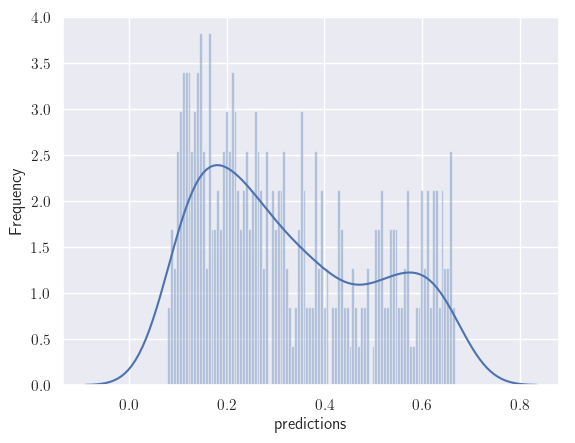

In [96]:
sns.distplot(np.log1p(results.predictions), kde = True, bins = 100)
plt.ylabel('Frequency')
plt.show()

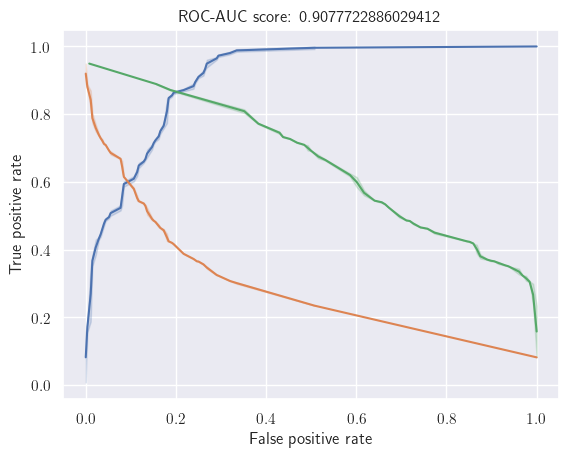

In [97]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = metrics.roc_curve(ytest, results.predictions, pos_label = 1)
sns.lineplot(fpr, tpr)
sns.lineplot(fpr, thresholds)
sns.lineplot(tpr, thresholds)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC-AUC score: {}'.format(roc_auc_score(ytest, results.predictions)))
plt.show()

In [98]:
results['bin_pred'] = results.predictions.apply(lambda x: 1 if x >= 0.355 else 0)

In [99]:
def prediction(ytest, ypred):
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('F1-score of the model: {}\n'.format(f1_score(ytest, ypred, average='weighted')))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

In [100]:
prediction(ytest, results['bin_pred'])

Accuracy of the model: 0.7975

F1-score of the model: 0.8041961714050592

Classification report: 
             precision    recall  f1-score   support

        0.0       0.95      0.74      0.83       272
        1.0       0.62      0.92      0.74       128

avg / total       0.85      0.80      0.80       400


Confusion matrix: 
[[201  71]
 [ 10 118]]



### Prediction on the 

In [48]:
all_samples = pd.DataFrame(predictions_samp).applymap(lambda x: 1 if x >= 0.355 else 0)

In [49]:
results.head()

,target,predictions,pred_std,pred_var,confidence_low,confidence_high,confidence_range,bin_pred
0,0,0.224500,0.155970,0.024327,-0.081195,0.530196,0.611391,0
1,1,0.979259,0.045604,0.002080,0.889877,1.068641,0.178764,1
2,0,0.099505,0.150729,0.022719,-0.195919,0.394928,0.590846,0
3,0,0.199640,0.146196,0.021373,-0.086899,0.486180,0.573079,0
4,1,0.658302,0.266837,0.071202,0.135310,1.181293,1.045983,1


In [45]:
np.array(all_samples)[:, 3]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [51]:
accuracies = []
for i in range(n_samples):
    ypred = all_samples.iloc[i]
    accuracies.append(f1_score(ytest, ypred, average='weighted'))

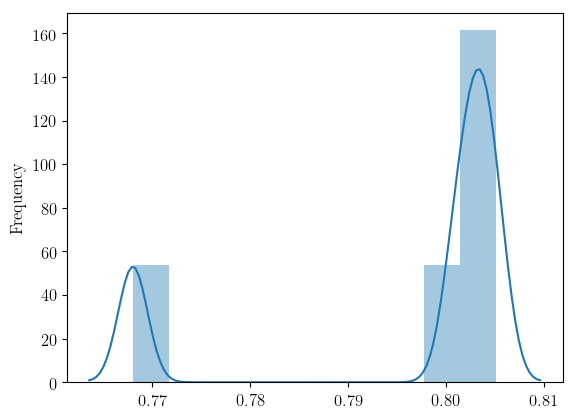

In [54]:
percent = [1]

for i in range(len(percent)):
    smapled_acc = np.random.choice(accuracies, size = int((percent[i]*n_samples)/100), replace = False)
    sns.distplot(smapled_acc, bins = 10)
    plt.ylabel('Frequency')
plt.show()

### Confidence interval

In [55]:
from scipy.stats import sem, t
from scipy import mean
confidence = 0.95

m = mean(accuracies)
std_err = sem(accuracies)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

print(m - h, m + h)

NameError: name 'n' is not defined

In [120]:
print(np.std(accuracies)*2, np.mean(accuracies), np.max(accuracies))

0.0963823294541069 0.7705435 0.8525


### Error analysis

In [56]:
correct = results[(results.target == results.bin_pred)]

In [57]:
incorrect = results[(results.target != results.bin_pred)]

In [58]:
correct.columns

Index(['target', 'predictions', 'pred_std', 'pred_var', 'confidence_low',
       'confidence_high', 'confidence_range', 'bin_pred'],
      dtype='object')

In [ ]:
np.a

In [59]:
incorrect.confidence_range[(incorrect.bin_pred == 0)].mean(axis = 0)

0.6316768553700873

In [60]:
correct.confidence_range[(correct.bin_pred == 0)].mean(axis = 0)

0.6429168172830712

In [61]:
sns.set(color_codes=True)

def plot_distribution(i):
    xxx = samplepredictions[:, i, 0]
    ax = sns.distplot(xxx, kde=False, fit=stats.gamma)
    ax2 = ax.twinx()
    sns.boxplot(x=xxx, ax=ax2)
    ax2.set(ylim=(-.5, 10))
    plt.show()

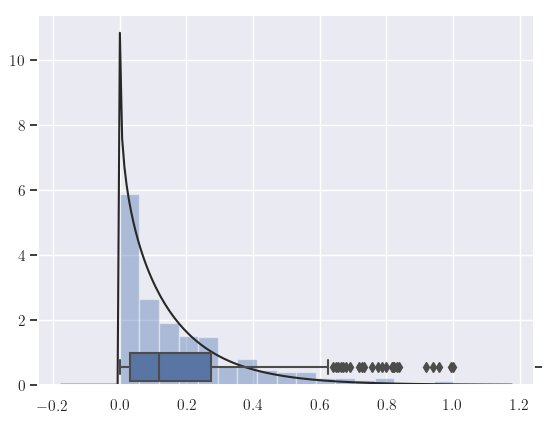

In [62]:
plot_distribution(66)

### Result vizualisation

In [196]:
pca = PCA(n_components = 2, random_state = 2018).fit_transform(xtest)

results['pca_x1'] = pca[:, 0]
results['pca_x2'] = pca[:, 1]

In [197]:
results.head()

,target,predictions,pred_std,pred_var,confidence_low,confidence_high,confidence_range,bin_pred,pca_x1,pca_x2
0,0,0.170807,0.136161,0.018540,-0.096063,0.437677,0.533740,0,0.557490,-1.138433
1,1,0.943406,0.096419,0.009297,0.754427,1.132384,0.377957,1,0.372588,2.210410
2,0,0.059954,0.133507,0.017824,-0.201715,0.321623,0.523338,0,-2.883425,-0.418066
3,0,0.177624,0.163858,0.026849,-0.143531,0.498779,0.642310,0,0.412756,-1.462043
4,1,0.452164,0.248501,0.061753,-0.034889,0.939217,0.974106,1,2.860224,0.236508


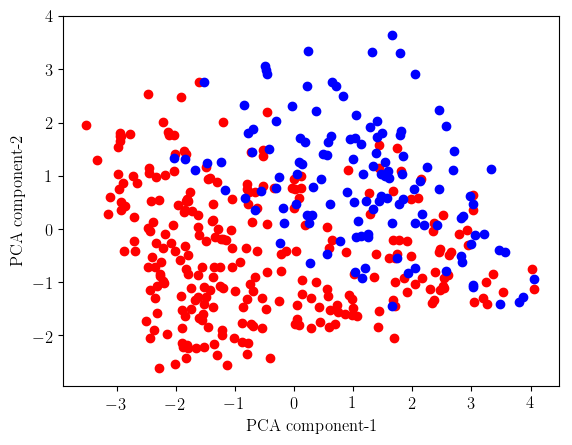

In [198]:
plt.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r')
plt.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b')

plt.xlabel('PCA component-1')
plt.ylabel('PCA component-2')
plt.show()

In [199]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [200]:
print(np.shape(grid), np.shape(grid_2d), np.shape(dummy_out))

(2, 100, 100) (10000, 2) (100,)


In [201]:
from matplotlib.mlab import griddata

xi = np.linspace(-4, 4, 100)
yi = np.linspace(-4, 4, 100)

Text(0,0.5,'Posterior predictive mean uncertainity')

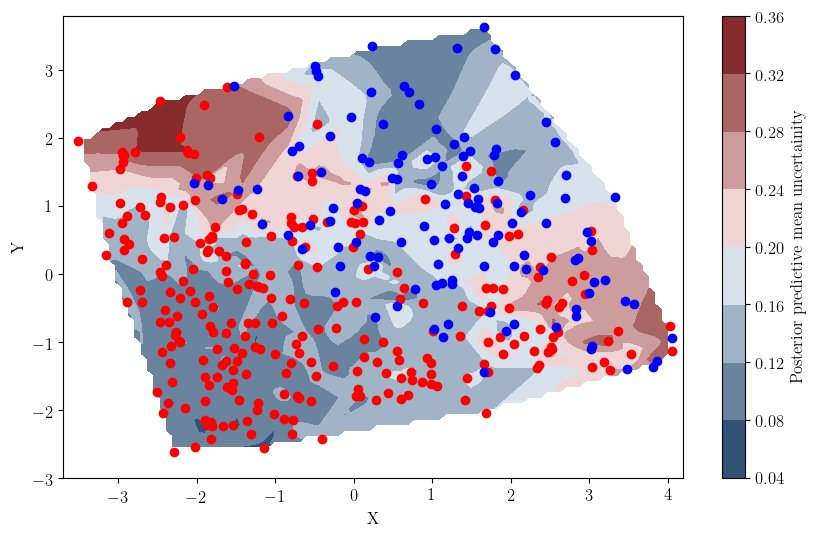

In [202]:
# grid the data.
zi = griddata(results.pca_x1, results.pca_x2, results.pred_std, xi, yi, interp='linear')

cmap = sns.diverging_palette(250, 12, s = 85, l = 25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(xi, yi, zi, cmap = cmap)
ax.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r')
ax.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b')

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3.7, 4.2), ylim=(-3, 3.8), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Posterior predictive mean uncertainity')

Text(0,0.5,'Posterior predictive mean probability')

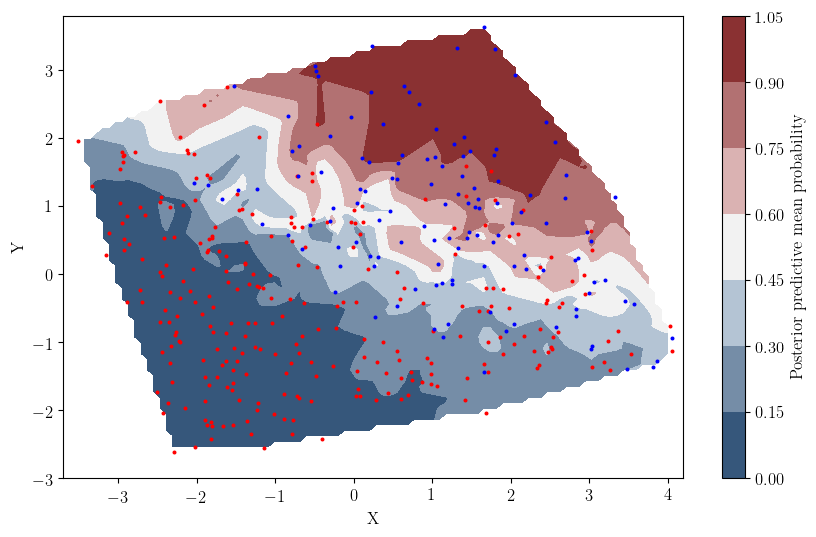

In [203]:
# grid the data.
zi = griddata(results.pca_x1, results.pca_x2, results.predictions, xi, yi, interp='linear')

cmap = sns.diverging_palette(250, 12, s = 85, l = 25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(xi, yi, zi, cmap = cmap)
ax.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r', s = 3.5)
ax.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b', s = 3.5)

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3.7, 4.2), ylim=(-3, 3.8), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Posterior predictive mean probability')

/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  


Text(0,0.5,'Posterior predictive mean probability')

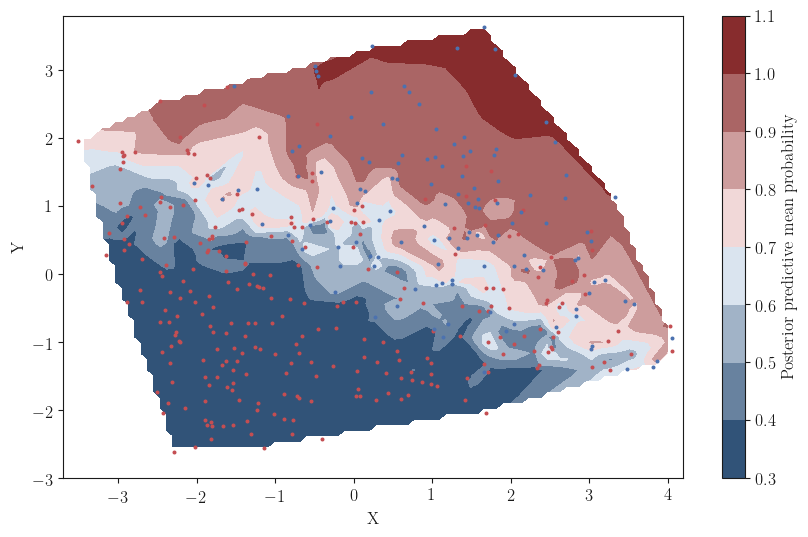

In [182]:
# grid the data.
zi = griddata(results.pca_x1, results.pca_x2, results.confidence_high, xi, yi, interp='linear')

cmap = sns.diverging_palette(250, 12, s = 85, l = 25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(xi, yi, zi, cmap = cmap)
ax.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r', s = 3.5)
ax.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b', s = 3.5)

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3.7, 4.2), ylim=(-3, 3.8), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Posterior predictive mean probability')

### CRITICISM

In [ ]:
x_post = ed.copy(x, {p: qp})

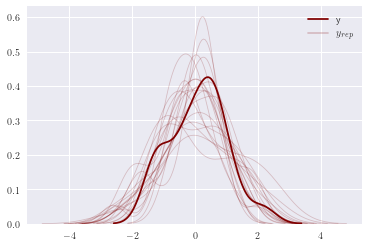

In [191]:
import matplotlib.pyplot as plt

y = np.random.randn(20)
y_rep = np.random.randn(20, 20)

ed.ppc_density_plot(y, y_rep)
plt.show()

In [ ]:
def define_network(images, num_classes=10):
    
     mean = tf.get_variable('mean', [28 * 28, num_classes])
     stddev = tf.get_variable('stddev', [28 * 28, num_classes])
     prior = tfd.MultivariateNormalDiag(
     tf.zeros_like(mean), tf.ones_like(stddev))
     posterior = tfd.MultivariateNormalDiag(mean, tf.nn.softplus(stddev))
     bias = tf.get_variable('bias', [num_classes]) # Or Bayesian, too
     logit = tf.nn.relu(tf.matmul(posterior.sample(), images) + bias)
     return tfd.Categorical(logit), posterior, prior

In [ ]:
dist, posterior, prior = define_network(images)
elbo = (tf.reduce_mean(dist.log_prob(label)) -
 tf.reduce_mean(tfd.kl_divergence(posterior, prior))